# Importing Libraries

In [ ]:
#from google.colab import files
#uploaded = files.upload()


In [1]:
import numpy as np, pandas as pd

#!pip install talos

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91758\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importing Data

In [2]:
train=pd.read_csv('D:/VIT/Sem 6/TARP/train.csv')

In [3]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
test=pd.read_csv('D:/VIT/Sem 6/TARP/test.csv')

In [5]:
test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


# Data Exploration

Checking for missing values

In [6]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [7]:
test.isnull().any()


id              False
comment_text    False
dtype: bool

In [8]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [9]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [10]:
#Ascii Removal step
def asciiremoval(string):
    string = re.sub('[^a-zA-Z.\d\s]', '', string)
    return string

#Removing dates
def remove_dates(sentence):
    for i in range(0,277):
        df1[i] = df1[i].sub('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{2}\s\d{4}', ' ', sentence)

#Removing Url
def remove_url(txt):
    txt_nourl=re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', txt)
    return txt_nourl

#Punctuation Removal
def removepunct(txt):
    txt_nopunct="".join((c for c in txt if c not in string.punctuation))
    return txt_nopunct

contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}










In [11]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)
    

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
#Ascii Removal
  text = re.sub('[^a-zA-Z.\d\s]', '', text)
#URL removal
  text=re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)
#Remove all the special characters 
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
#Date Removal 
  text=re.sub('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{2}\s\d{4}', ' ', text)
  text= re.sub('[^a-zA-Z.\d\s]', '', text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 





Cleaning Training Data

In [12]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'daww he matches this background colour im seemingly stuck with thanks talk january utc'

Cleaning Test Data

In [13]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

In [14]:
#train.to_csv('Data/train_preprocessed_first.csv')
#test.to_csv('Data/test_preprocessed_first.csv')

In [15]:
#test=pd.read_csv('Data/train_preprocessed_first.csv')
#train=pd.read_csv('Data/test_preprocessed_first.csv')

## Lemmatization

In [16]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [17]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [18]:
wordnet_lemmatizer = WordNetLemmatizer()

In [19]:
#Lemmatization
#Pos Tagging-Noun,verb,adjective,adverb
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

Lemmatizing Training Data

In [20]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

In [21]:
lemmatized_train_data[152458]

'i agree with you about graemels intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wprr threerevertrule notice board post by report the revert nazi graemel ha show himselfherself to be a revert nazi this be unacceptable on a site that be make by it user and not it admins if you feel you have be unjustly revert more than time over a hour period please report himher to the threerevertnoticeboard wprr it be time to take back what be ours'

Lemmatizing Test Data

In [22]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

## Stopwords Removal

In [23]:
stopword_list=STOP_WORDS

Adding Single and Dual to STOP_WORDS

In [24]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [25]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [26]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

In [27]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [28]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

In [29]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [30]:
def string_combine(stopword):
  final_a=""
  for item in range(1,159571):
    final_a=final_a+" "+stopword[item]
  return final_a



In [31]:
total_string_potential = ''.join([word for word in potential_stopwords])

In [32]:
print(potential_stopwords)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Counting the number of words in each of the 4 strings

In [33]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [34]:
total_string_potential_dict=word_count(total_string_potential)


Converting Dictionaries to Dataframe

In [35]:
total_string_potential_df = pd.DataFrame(list(total_string_potential_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [36]:
total_string_potential_df

,Word,Count
0,explanation,1924
1,edit,36924
2,username,1713
3,hardcore,144
4,metallica,34
...,...,...
313518,ciu,1
313519,relevantnumber,1
313520,significantashamed,1
313521,pagespitzer,1


Retaining certain words and removing others from the above list

In [37]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

Adding above retrived words into the stopwords list

In [38]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [39]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [40]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

In [41]:
processed_train_data[152458]

'agree graemels intention revert nazi protect report wprr threerevertrule notice board post report revert nazi graemel himselfherself revert nazi unacceptable site admins feel unjustly revert hour period report himher threerevertnoticeboard wprr'

Removing Stopwords from Test Data

In [42]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=153164): 
    processed_test_data.append(remove_stopwords(line))

# Model Building

In [43]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [44]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [45]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  195330


Padding

In [46]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [47]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  137   562 32684   241   188 32684   241    93    17   559    17   137
   361   562     1  1055   137   329  5354   137   147    17   379   286
   361   562    17     1  1312   137    17   379     2    32   137   562
   188   137   175    45    89   559   137   562    17     2   480   111
    10  1063   420  1066    17  2321   510    36   137    17   188   394
   361     9   252   188   239   146   109    19    20    28   175    77
    20     3   318  4415     5 32684   241   188 32684   241    93   256
   379   300    60   559    37    44    77   422  1495    37   256     8
   559  1281    77  1600   125    10   125  4610   125   101    44   541
  1219    14    77  1327   114   125  1628    77  1097     5   498    77
   455    34   256    60  3222   165  2205   461    34   319  1511    68
   175   233   146  2513    34    34  1517    77  4648  1517    77    34
    77    34   188   256    45    89   559     5    34   256   188    79
    10   833  3087    17    

In [48]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [49]:
X_t = X_t[indices]
labels = y[indices]
print('Features are :','\n',X_t)
print('labels are:','\n',labels)

Features are : 
 [[ 1857  6024  3008 ...     0     0     0]
 [  166   630   644 ...     0     0     0]
 [11971 16776 14898 ...     0     0     0]
 ...
 [   47    61   334 ...     0     0     0]
 [    4    42  4689 ...     0     0     0]
 [99044   974    15 ...     0     0     0]]
labels are: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


### Splitting data into Training and Validation Set

In [50]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]


In [51]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12177  1271  6769   368  6226  1117]
validation:  [3117  324 1680  110 1651  288]


### Importing Fast Text

In [52]:
#import requests, zipfile, io

#zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

#r = requests.get(zip_file_url)

#z = zipfile.ZipFile(io.BytesIO(r.content))

#z.extractall()


In [53]:
import codecs
embeddings_index_fasttext = {}

f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')


for line in f:

    values = line.rstrip().rsplit(' ')

    word = values[0]

    coefs = np.asarray(values[1:], dtype='float32')

    embeddings_index_fasttext[word] = coefs

f.close()


In [54]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
        
print("Completed!")
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix_fasttext, axis=1) == 0))

Completed!
number of null word embeddings: 0


### Creating Model

In [55]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Model, load_model
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, GRU, GlobalMaxPooling1D, Dense



def build_model():
    inp=Input(shape=(maxpadlen, ),dtype='int32')
    x = Embedding(195331, embedding_dim_fasttext, weights=[embedding_matrix_fasttext], trainable = False)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.5,  return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(6, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    return model


model_gru = build_model()
model_gru.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_gru.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          58599300  
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         330240    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                             

#### Training Model with Best Parameters

GRU

In [56]:
inp=Input(shape=(maxpadlen, ),dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [57]:
model_info_1=model_gru.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 5934s 1s/step - loss: 0.0636 - accuracy: 0.9763 - val_loss: 0.0570 - val_accuracy: 0.9752
Epoch 2/2
3990/3990 [==============================] - 6365s 2s/step - loss: 0.0532 - accuracy: 0.9800 - val_loss: 0.0533 - val_accuracy: 0.8786


## Plotting Graphs

### GRU

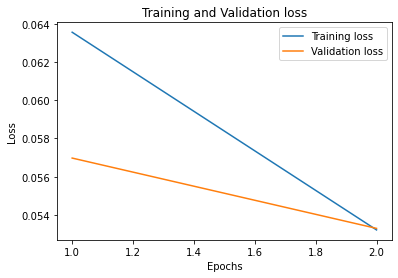

In [58]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

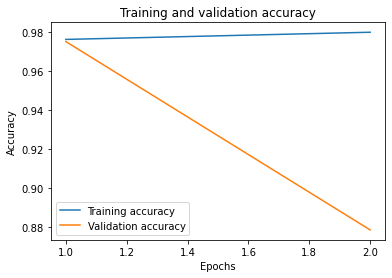

In [59]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Saving the Model

In [60]:
model_gru.save('Data/model_GRU')

INFO:tensorflow:Assets written to: Data/model_GRU\assets


INFO:tensorflow:Assets written to: Data/model_GRU\assets


# Loading Saved Model

In [61]:
loaded_model_gru = keras.models.load_model('Data/model_GRU')

# Generating the Output

### GRU

In [62]:
test_values_1 = loaded_model_gru.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 28346s 185ms/step


In [63]:
sample_submission = pd.read_csv(r'D:\VIT\Sem 6\TARP\sample_submission.csv')
test_values_1=pd.DataFrame(test_values_1,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_1],axis=1)
combined_submission.to_csv(r'D:\VIT\Sem 6\TARP\sample_submission.csv', index=False)

# Testing the Created Model

In [64]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = loaded_model_gru.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [65]:
toxicity_level('go jump off a bridge jerk')

1/1 [==============================] - 1s 1s/step
Toxicity levels for 'go jump off a bridge jerk':
Toxic:         82%
Severe Toxic:  2%
Obscene:       57%
Threat:        1%
Insult:        45%
Identity Hate: 2%



In [66]:
toxicity_level('i will kill you')

1/1 [==============================] - 0s 316ms/step
Toxicity levels for 'i will kill you':
Toxic:         31%
Severe Toxic:  1%
Obscene:       12%
Threat:        3%
Insult:        4%
Identity Hate: 1%



In [67]:
toxicity_level('have a nice day')

1/1 [==============================] - 0s 310ms/step
Toxicity levels for 'have a nice day':
Toxic:         1%
Severe Toxic:  0%
Obscene:       1%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [68]:
toxicity_level('fuck ofF!!')

1/1 [==============================] - 0s 316ms/step
Toxicity levels for 'fuck ofF!!':
Toxic:         99%
Severe Toxic:  32%
Obscene:       100%
Threat:        2%
Insult:        70%
Identity Hate: 7%



In [69]:
toxicity_level('Hello, How are you?')

1/1 [==============================] - 0s 305ms/step
Toxicity levels for 'Hello, How are you?':
Toxic:         1%
Severe Toxic:  0%
Obscene:       1%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [70]:
toxicity_level('get the fuck away from me @sshole!!')

1/1 [==============================] - 0s 302ms/step
Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         99%
Severe Toxic:  34%
Obscene:       100%
Threat:        3%
Insult:        63%
Identity Hate: 7%

